In [18]:
import sys
import os
import warnings
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import drpy
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import shapely.geometry as sgeom
from matplotlib.gridspec import GridSpec
from datetime import datetime
from re import split
from matplotlib.animation import ArtistAnimation
warnings.filterwarnings('ignore')
# from dask.distributed import Client, LocalCluster
# cluster = LocalCluster()
# client = Client(cluster)

sys.path.insert(1, f"{os.path.abspath(os.path.join(os.path.abspath(''), '../'))}")
from src.utils import time_3d, get_pars_from_ini
location = split(', |_|-|!', os.popen('hostname').read())[0]
path_data = get_pars_from_ini(campaign='loc')[location]['path_data']

plt.rcParams['animation.html'] = 'jshtml'
%matplotlib inline

In [19]:
ds_xr = xr.open_zarr(f'{path_data}/zarr/KUsKAs_Wn/lores.zarr')

In [20]:
ds_xr.scantime.values.dtype

dtype('float64')

In [21]:
ds_xr.time

<xarray.DataArray 'time' (time: 89835)>
array(['2019-08-24T22:59:26.499800000', '2019-08-24T22:59:28.349800000',
       '2019-08-24T22:59:30.199800000', ..., '2019-10-05T06:53:48.799800000',
       '2019-10-05T06:53:50.649800000', '2019-10-05T06:53:52.499800000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2019-08-24T22:59:26.499800 ... 2019-10-05T...

In [22]:
ds_xr.time.min()

<xarray.DataArray 'time' ()>
array('2019-08-24T22:59:26.499800000', dtype='datetime64[ns]')

In [23]:
ds_xr.time.max()

<xarray.DataArray 'time' ()>
array('2019-10-05T06:53:52.499800000', dtype='datetime64[ns]')

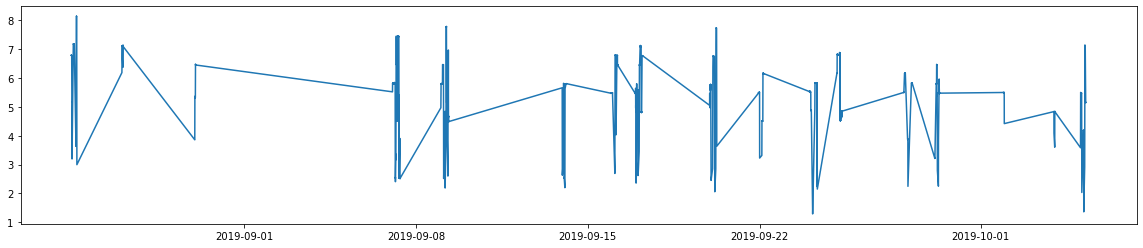

In [24]:
fig, ax = plt.subplots(figsize=(20,4))
plt.plot(ds_xr.time, ds_xr.alt_nav[12, :] / 1000)

In [25]:
ds_aug = ds_xr.sel(time=('2019-09'))

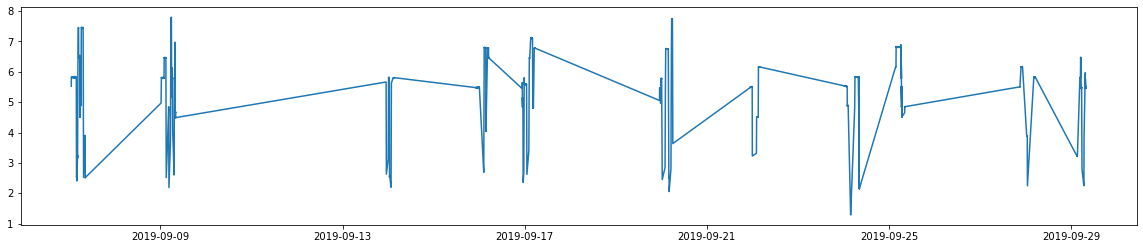

In [26]:
fig, ax = plt.subplots(figsize=(20,4))
plt.plot(ds_aug.time, ds_aug.alt_nav[12, :] / 1000)

In [27]:
 _, index = np.unique(ds_xr['time'], return_index=True)
ds_nw = ds_xr.sel(time=~ds_xr.get_index("time").duplicated())

In [28]:
ds_dates = ds_nw.sel(time=slice('2019-09-16 03:12:40', '2019-09-16 03:13:40'))

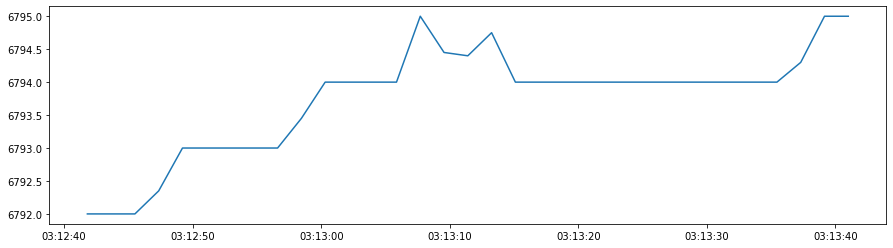

In [29]:
fig, ax = plt.subplots(figsize=(15,4))
plt.plot(ds_dates.time, ds_dates.alt_nav[12, :])

execution time: 0:00:33.402899


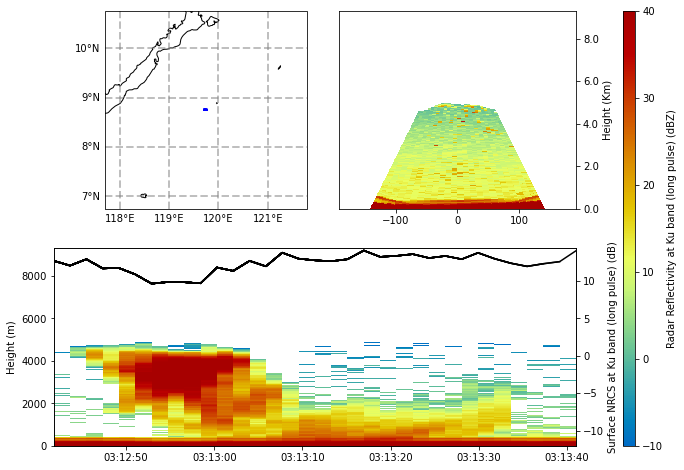

In [30]:
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[-1, :])
ax4 = ax3.twinx()

artist = []
now = datetime.now()
for _time in ds_dates.time:
    time = _time
    ax1.set_extent([ds_dates.lon.max() + 2, ds_dates.lon.min() - 2, 
                    ds_dates.lat.min() - 2, ds_dates.lat.max() + 2], 
                   crs=ccrs.Geodetic())
    if time == ds_dates.time.min():
        _lon = ds_dates.lon.sel(time=slice(ds_dates.time.min(), time))
        _lat = ds_dates.lat.sel(time=slice(ds_dates.time.min(), time))
    else:
        _lon = ds_dates.lon.sel(time=slice(ds_dates.time.min(), time)).values[12, :]
        _lat = ds_dates.lat.sel(time=slice(ds_dates.time.min(), time)).values[12, :]
        
    track = sgeom.LineString(zip(_lon, _lat))
    im1 = ax1.add_geometries([track], ccrs.PlateCarree(), facecolor='none', edgecolor='blue',
                       linewidth=2)

    x = ds_dates.range * np.sin(np.deg2rad(ds_dates.azimuth.sel(time=time)))
    y = ds_dates.alt3D.sel(time=time) * np.cos(np.deg2rad(ds_dates.azimuth.sel(time=time)))
    im2 = ax2.pcolormesh(x, y, ds_dates.zhh14.sel(time=time), 
                         cmap=drpy.graph.cmaps.HomeyerRainbow, vmin=-10, vmax=40)
    # ax2.invert_yaxis()  # for plane relative coordinates
    ax2.set_ylim(0, y.max())
    times_3d = time_3d(ds_dates.scantime.sel(time=slice(ds_dates.time.min(), time)), 
                       ds_dates.alt3D.shape[0])
    im3 = ax3.pcolormesh(times_3d[:, 12, :],
                       ds_dates.alt3D.sel(time=slice(ds_dates.time.min(), time))[:, 12, :],
                       ds_dates.zhh14.sel(time=slice(ds_dates.time.min(), time))[:, 12, :],
                       cmap=drpy.graph.cmaps.HomeyerRainbow, vmin=0, vmax=40)
    ax3.set_ylim(0, y.max())
    ax3.set_xlim(ds_dates.time.min(), ds_dates.time.max())
    im4, = ax4.plot(times_3d[0, 12, :], ds_dates.s0hh14.sel(time=slice(ds_dates.time.min(), time))[12], 'k')
    ax4.set_ylim(ds_dates.s0hh14.min(), ds_dates.s0hh14.max())
    artist.append([im1, im2, im3, im4])
    
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray',
                   alpha=0.5, linestyle='--')
gl.right_labels = False
gl.top_labels = False
ax1.coastlines()
labels = [i / 1000 for i in ax2.get_yticks()]
ax2.set_yticklabels(labels)
ax2.set_ylabel('Height (Km)')
ax2.yaxis.set_label_position("right")

ax2.yaxis.tick_right()

cbar2 = plt.colorbar(im2, ax=[ax2, ax3], orientation='vertical', aspect=35,  pad=0.07)
cbar2.set_label(f'{ds_dates.zhh14.notes} ({ds_dates.zhh14.units})')
ax3.set_ylabel('Height (m)')
ax4.set_ylabel(f'{ds_dates.s0hh14.notes} ({ds_dates.s0hh14.units})')
end = datetime.now()
print(f'execution time: {(end - now)}')

In [31]:
anim = ArtistAnimation(fig, artist, interval=100, blit=True)
anim

In [32]:
ds_nw.time.values[0]

numpy.datetime64('2019-08-24T22:59:26.499800000')